In [1]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.stats import pearsonr
import matplotlib.gridspec as gridspec

In [2]:
# Data information:
# - input_noisy: Input data with 5% noise added
# - input: Input data without noise
# - The dataset contains patches of 9x9 voxels, with 8 different inversion times (P=8)
# - The goal is to reconstruct spectra for 32 different T1 times (Q=32)

In [3]:
data = mat73.loadmat('../data/training_data_T1_3D_9x9x32x47932_noise0.05.mat')
data.keys()

dict_keys(['input', 'input_noisy', 'ref'])

In [4]:
input_noisy = data['input_noisy']
input_clean = data['input']
ref = data['ref']

In [5]:
print("Shape of input data:", input_clean.shape)
print("Shape of noisy input data:", input_noisy.shape)
print("Shape of reference data:", ref.shape)

Shape of input data: (9, 9, 8, 47932)
Shape of noisy input data: (9, 9, 8, 47932)
Shape of reference data: (9, 9, 32, 47932)


In [ ]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

In [ ]:
# Peak Analysis
def count_peaks(signal):
    """Counts peaks in a signal, handling NaNs."""
    signal_no_nan = np.nan_to_num(signal, nan=0)  # Replace NaN with 0 for peak finding
    peaks, _ = find_peaks(signal_no_nan, prominence=0.05)
    return len(peaks)

def find_example_for_peaks(ref_data, target_peaks):
    """Finds an example spectrum with a specific number of peaks."""
    spectra = ref_data[4, 4, :, :]  # Central voxel

    for i in range(spectra.shape[1]):
        spectrum = spectra[:, i]
        if count_peaks(spectrum) == target_peaks:
            return spectrum, i
    return None, None

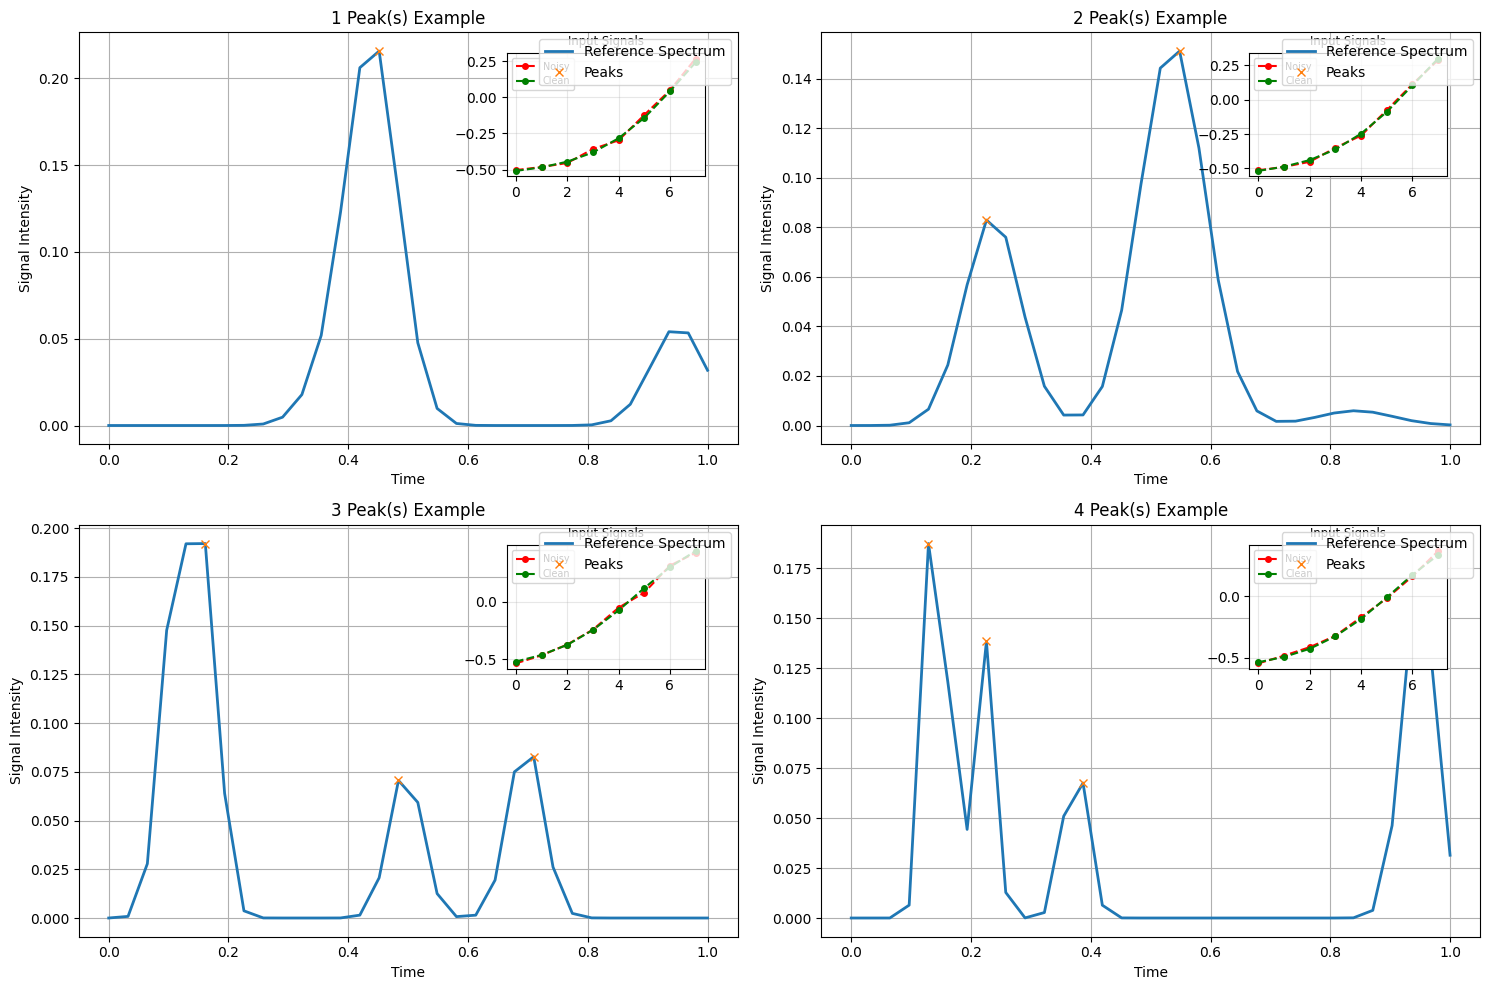

In [ ]:
t1_times = np.linspace(0, 1, 32)  # For reference data
inversion_times = np.arange(8)     # For input data

peak_examples = {}
for num_peaks in [1, 2, 3, 4]:
    spectrum, idx = find_example_for_peaks(ref, num_peaks)
    if spectrum is not None:
        peak_examples[num_peaks] = (spectrum, idx)

# Create the plot
plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2)

for i, (num_peaks, (spectrum, idx)) in enumerate(peak_examples.items(), 1):
    ax_main = plt.subplot(gs[i - 1])

    ax_main.plot(t1_times, spectrum, '-', linewidth=2, label='Reference Spectrum')
    
    spectrum_no_nan = np.nan_to_num(spectrum, nan=0)
    peaks, _ = find_peaks(spectrum_no_nan, prominence=0.05)
    ax_main.plot(t1_times[peaks], spectrum[peaks], "x", label='Peaks')

    ax_inset = ax_main.inset_axes([0.65, 0.65, 0.3, 0.3])

    ax_inset.plot(inversion_times, input_noisy[4, 4, :, idx], 'ro--', markersize=4, label='Noisy')
    ax_inset.plot(inversion_times, input_clean[4, 4, :, idx], 'go--', markersize=4, label='Clean')

    ax_main.set_title(f'{num_peaks} Peak(s) Example')
    ax_main.set_xlabel('Time')
    ax_main.set_ylabel('Signal Intensity')
    ax_main.legend()
    ax_main.grid(True)

    ax_inset.grid(True, alpha=0.3)
    ax_inset.legend(fontsize='x-small')
    ax_inset.set_title('Input Signals', fontsize='small')

plt.tight_layout()
plt.show()

In [10]:
# Print example arrays (2-peak)
if 2 in peak_examples:
    _, idx = peak_examples[2]
    print("\nExample arrays for 2-peak signal:")
    print("\nNoisy input data:")
    print(input_noisy[4, 4, :, idx])
    print("\nClean input data:")
    print(input_clean[4, 4, :, idx])
    print("\nReference data:")
    print(ref[4, 4, :, idx])


Example arrays for 2-peak signal:

Noisy input data:
[-0.51409197 -0.48881173 -0.45195043 -0.34947002 -0.2607468  -0.07551418
  0.1134821   0.28950745]

Clean input data:
[-0.51815474 -0.48759028 -0.43918708 -0.36184233 -0.24667077 -0.08859888
  0.10455551  0.30054635]

Reference data:
[3.31005396e-07 7.90793820e-06 1.18573094e-04 1.11584540e-03
 6.59047998e-03 2.44300924e-02 5.68366162e-02 8.29901099e-02
 7.60539174e-02 4.37493101e-02 1.58662107e-02 4.21230122e-03
 4.26525716e-03 1.57679189e-02 4.65486385e-02 9.74701643e-02
 1.44371897e-01 1.51256397e-01 1.12089165e-01 5.87582849e-02
 2.18208693e-02 5.88898920e-03 1.67128933e-03 1.75478798e-03
 3.27651785e-03 5.04232384e-03 5.95541345e-03 5.37906447e-03
 3.71460849e-03 1.96110504e-03 7.91502651e-04 2.44208233e-04]


NaN values in noisy input: True
NaN values in clean input: True
NaN values in reference data: False
Total NaN values in Noisy Input: 1635840


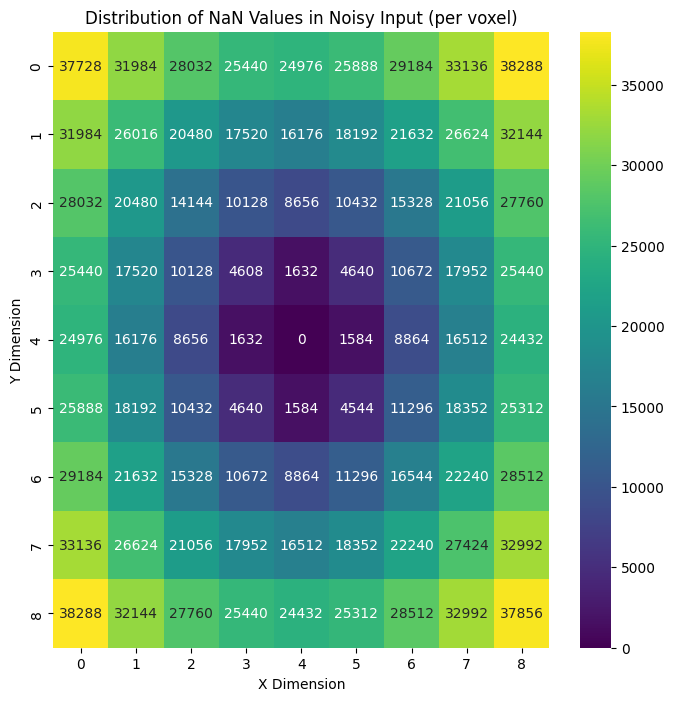

Total NaN values in Clean Input: 1635840


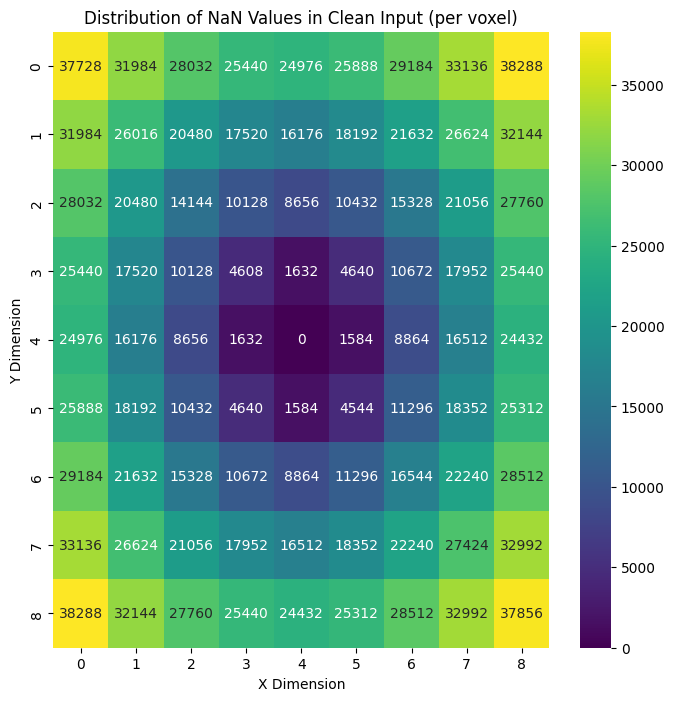

In [ ]:
# NaN Value Analysis
has_nan_noisy = np.isnan(input_noisy).any()
has_nan_clean = np.isnan(input_clean).any()
has_nan_ref = np.isnan(ref).any()

print(f"NaN values in noisy input: {has_nan_noisy}")
print(f"NaN values in clean input: {has_nan_clean}")
print(f"NaN values in reference data: {has_nan_ref}")

# Distribution of NaNs
if has_nan_noisy or has_nan_clean or has_nan_ref:
    datasets = [('Noisy Input', input_noisy, has_nan_noisy),
                ('Clean Input', input_clean, has_nan_clean),
                ('Reference Data', ref, has_nan_ref)]

    for name, data, has_nan in datasets:
        if has_nan:
            nan_count = np.isnan(data).sum()
            print(f"Total NaN values in {name}: {nan_count}")
            nan_distribution = np.isnan(data).sum(axis=(2, 3))
            plt.figure(figsize=(8, 8))
            sns.heatmap(nan_distribution, annot=True, fmt="d", cmap="viridis")
            plt.title(f"Distribution of NaN Values in {name} (per voxel)")
            plt.xlabel("X Dimension")
            plt.ylabel("Y Dimension")
            plt.show()

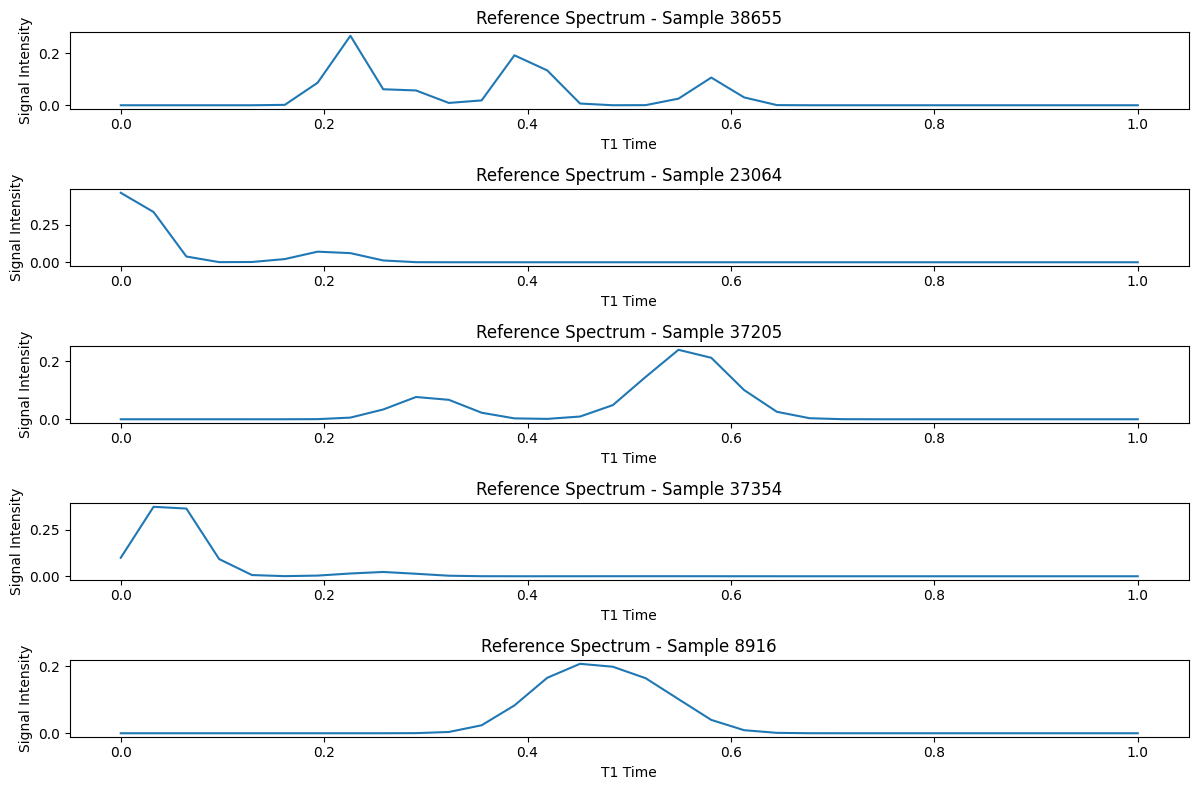

In [ ]:
# Signal/Peak Analysis
num_spectra_to_plot = 5 # random
random_indices = np.random.choice(ref.shape[3], size=num_spectra_to_plot, replace=False)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    spectrum = ref[4, 4, :, idx]  # Central voxel
    plt.subplot(num_spectra_to_plot, 1, i + 1)
    plt.plot(t1_times, spectrum)
    plt.title(f"Reference Spectrum - Sample {idx}")
    plt.xlabel("T1 Time")
    plt.ylabel("Signal Intensity")
plt.tight_layout()
plt.show()

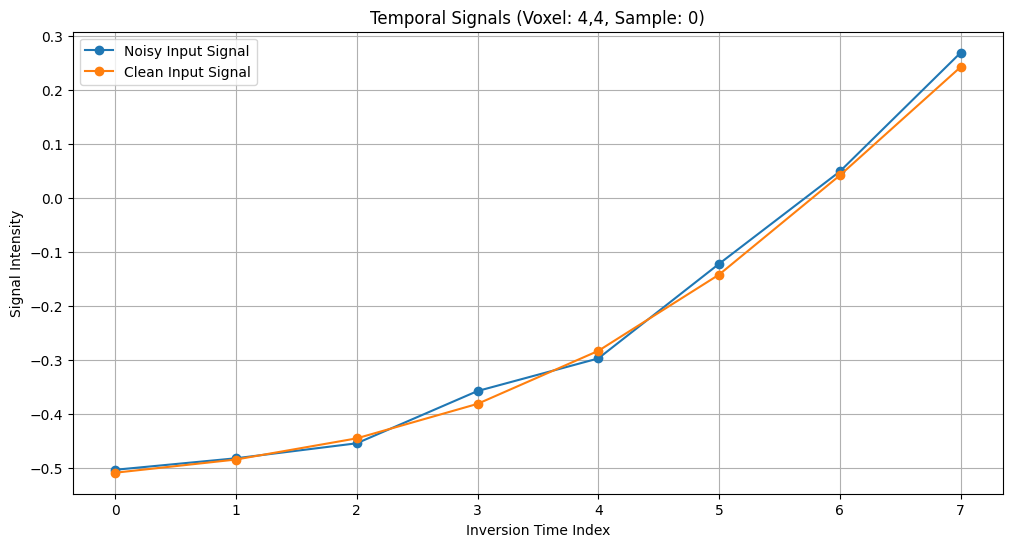

In [ ]:
# Temporal Signal Visualization (Single Voxel)
sample_idx = 0
x_voxel = 4
y_voxel = 4

noisy_temporal_signal = input_noisy[x_voxel, y_voxel, :, sample_idx]
clean_temporal_signal = input_clean[x_voxel, y_voxel, :, sample_idx]

plt.figure(figsize=(12, 6))
plt.plot(inversion_times, noisy_temporal_signal, 'o-', label='Noisy Input Signal')
plt.plot(inversion_times, clean_temporal_signal, 'o-', label='Clean Input Signal')
plt.title(f"Temporal Signals (Voxel: {x_voxel},{y_voxel}, Sample: {sample_idx})")
plt.xlabel("Inversion Time Index")
plt.ylabel("Signal Intensity")
plt.legend()
plt.grid(True)
plt.show()

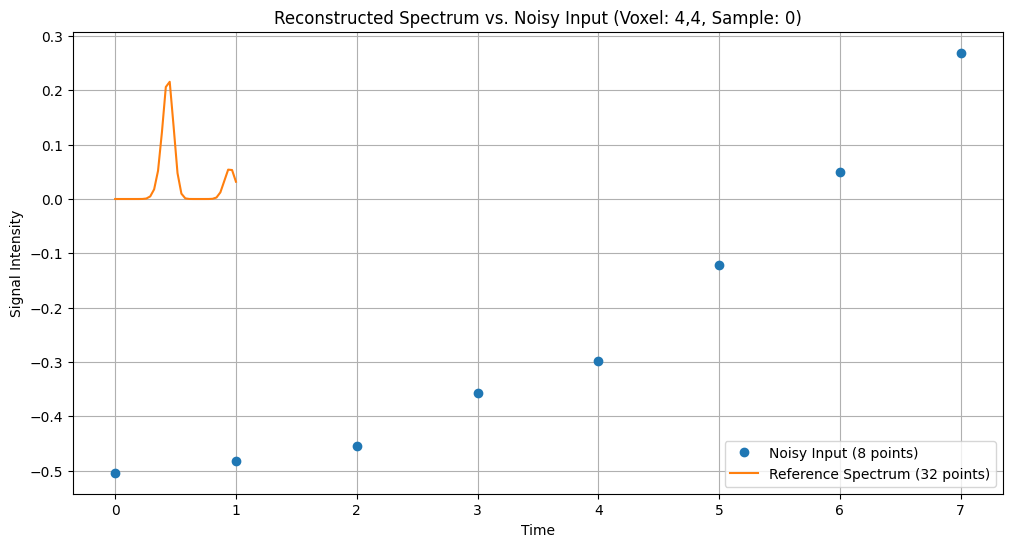

In [ ]:
# Reconstructed Spectrum vs. Input
plt.figure(figsize=(12, 6))
plt.plot(inversion_times, noisy_temporal_signal, 'o', label='Noisy Input (8 points)')
plt.plot(t1_times, ref[x_voxel, y_voxel, :, sample_idx], '-', label='Reference Spectrum (32 points)')
plt.title(f"Reconstructed Spectrum vs. Noisy Input (Voxel: {x_voxel},{y_voxel}, Sample: {sample_idx})")
plt.xlabel("Time")
plt.ylabel("Signal Intensity")
plt.legend()
plt.grid(True)
plt.show()


--- Spatial Variation of Spectra ---


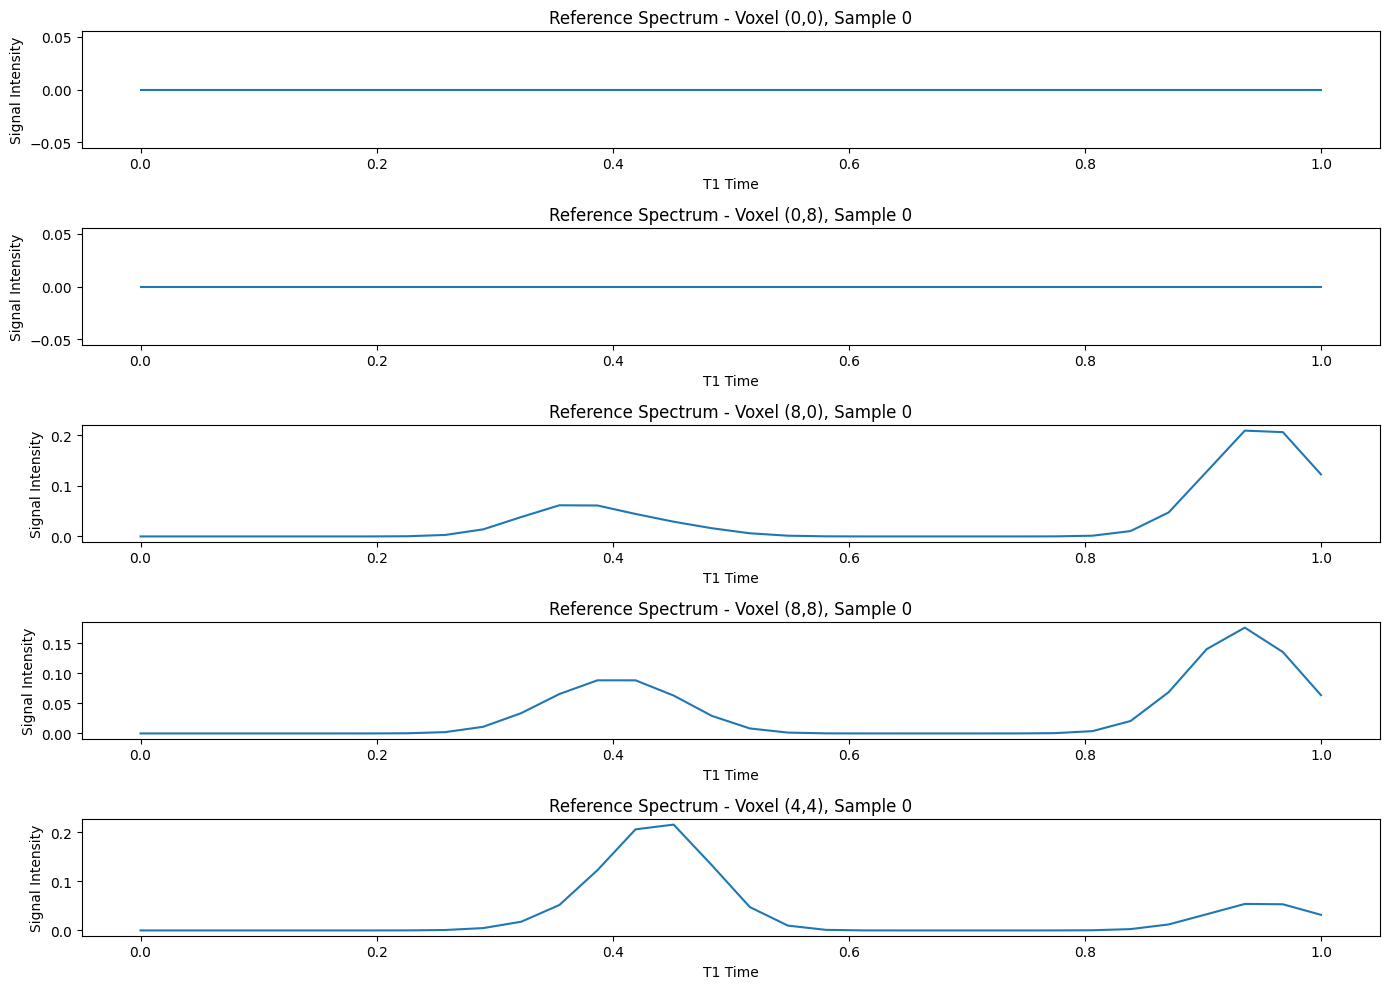

In [ ]:
# Spatial Variation of Spectra

spatial_locations = [(0, 0), (0, 8), (8, 0), (8, 8), (4, 4)]
plt.figure(figsize=(14, 10))
for i, (x, y) in enumerate(spatial_locations):
    spectrum = ref[x, y, :, sample_idx]
    plt.subplot(len(spatial_locations), 1, i + 1)
    plt.plot(t1_times, spectrum)
    plt.title(f"Reference Spectrum - Voxel ({x},{y}), Sample {sample_idx}")
    plt.xlabel("T1 Time")
    plt.ylabel("Signal Intensity")
plt.tight_layout()
plt.show()

Mean of the noise: 0.00020501115
Standard deviation of the noise: 0.016121145


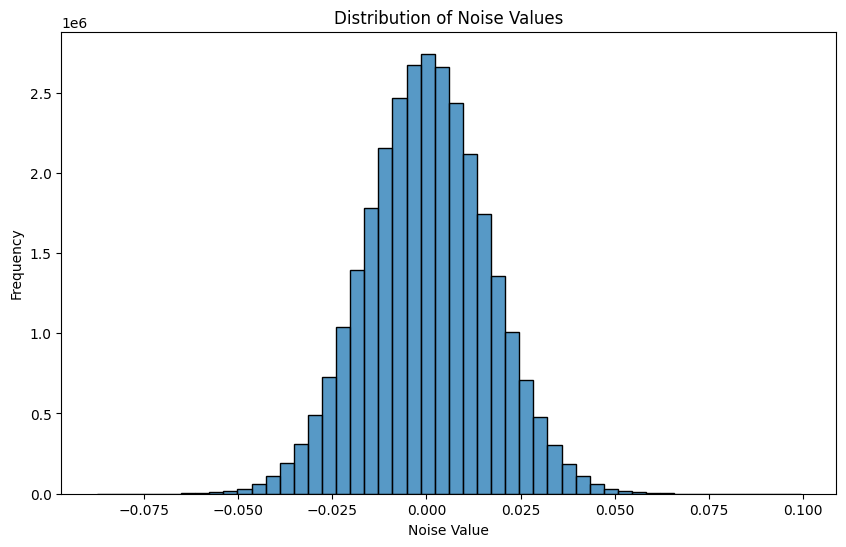

Correlation of noise between neighboring voxels (x,y): 0.0041


In [ ]:
# Noise Analysis

noise = np.where((~np.isnan(input_noisy)) & (~np.isnan(input_clean)), input_noisy - input_clean, np.nan)
mean_noise = np.nanmean(noise)
std_noise = np.nanstd(noise)
print("Mean of the noise:", mean_noise)
print("Standard deviation of the noise:", std_noise)

plt.figure(figsize=(10, 6))
sns.histplot(noise[~np.isnan(noise)].flatten(), bins=50)
plt.title("Distribution of Noise Values")
plt.xlabel("Noise Value")
plt.ylabel("Frequency")
plt.show()

# Noise correlation (neighboring voxels)
noise_voxel1 = noise[4, 4, :, :].flatten()
noise_voxel2 = noise[4, 5, :, :].flatten()
valid_indices = ~np.isnan(noise_voxel1) & ~np.isnan(noise_voxel2)
noise_voxel1_valid = noise_voxel1[valid_indices]
noise_voxel2_valid = noise_voxel2[valid_indices]

if len(noise_voxel1_valid) > 1:
    correlation_noise_xy = pearsonr(noise_voxel1_valid, noise_voxel2_valid)[0]
    print(f"Correlation of noise between neighboring voxels (x,y): {correlation_noise_xy:.4f}")
else:
    print("Not enough non-NaN values for noise correlation.")

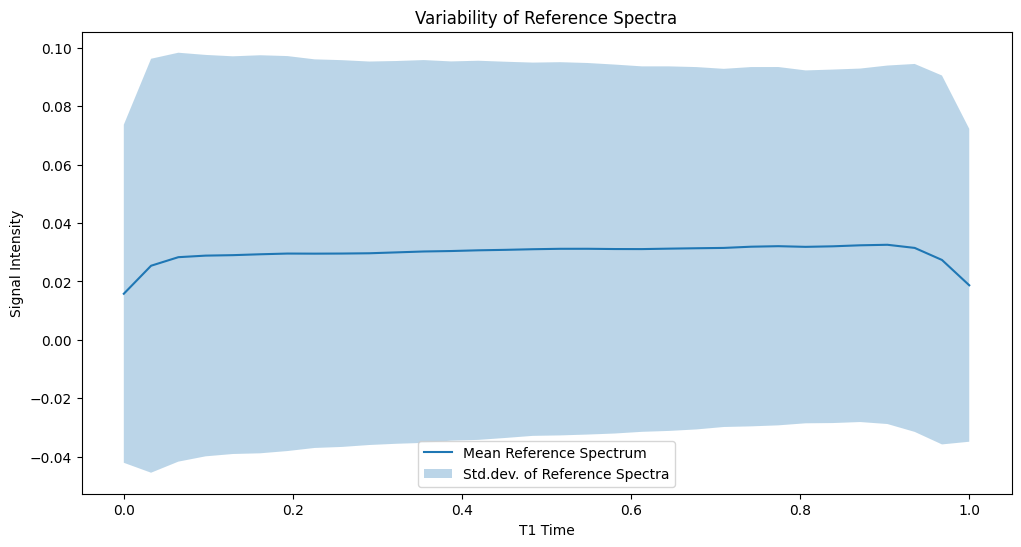

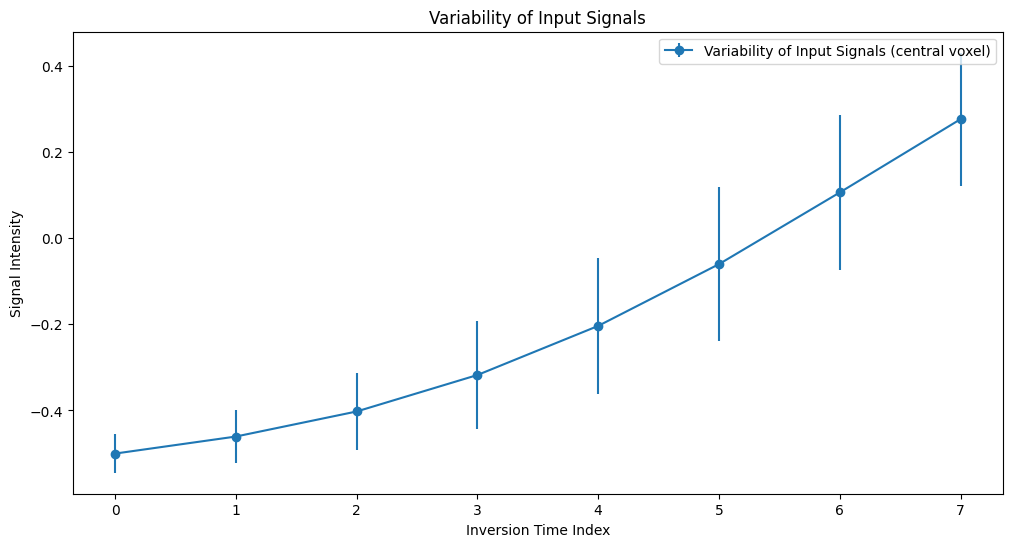

In [ ]:
# Signal Variability Analysis

std_ref_spectra = np.nanstd(ref, axis=3)  # Standard deviation over samples
std_input_signals = np.nanstd(input_clean, axis=3)

# Variability of Reference Spectra
plt.figure(figsize=(12, 6))
mean_ref = np.nanmean(ref, axis=(0, 1, 3)) #Mean across voxels and samples
std_mean_ref = np.nanmean(std_ref_spectra, axis=(0, 1)) #Mean across voxels
plt.plot(t1_times, mean_ref, label="Mean Reference Spectrum")
plt.fill_between(t1_times, mean_ref - std_mean_ref, mean_ref + std_mean_ref, alpha=0.3, label="Std.dev. of Reference Spectra")
plt.title("Variability of Reference Spectra")
plt.xlabel("T1 Time")
plt.ylabel("Signal Intensity")
plt.legend()
plt.show()

# Variability of Input Signals (central voxel)
plt.figure(figsize=(12, 6))
mean_input_voxel = np.nanmean(input_clean[4, 4, :, :], axis=1)
std_input_voxel = np.nanstd(input_clean[4, 4, :, :], axis=1)
plt.errorbar(inversion_times, mean_input_voxel, yerr=std_input_voxel, fmt='o-', label="Variability of Input Signals (central voxel)")
plt.title("Variability of Input Signals")
plt.xlabel("Inversion Time Index")
plt.ylabel("Signal Intensity")
plt.legend()
plt.show()

In [20]:
# Spatial Correlation Analysis

central_spectrum = ref[4, 4, :, :]
neighbor_spectra = [
    ref[3, 4, :, :], ref[5, 4, :, :], ref[4, 3, :, :], ref[4, 5, :, :]
]

correlations = []
for neighbor in neighbor_spectra:
    temp_correlations = []
    for i in range(central_spectrum.shape[1]):
        valid_indices = ~np.isnan(central_spectrum[:, i]) & ~np.isnan(neighbor[:, i])
        if np.sum(valid_indices) > 1:
            corr, _ = pearsonr(central_spectrum[valid_indices, i], neighbor[valid_indices, i])
            temp_correlations.append(corr)
        else:
            temp_correlations.append(np.nan)
    correlations.append(np.nanmean(temp_correlations))

print("Correlation with the upper neighbor:", correlations[0])
print("Correlation with the lower neighbor:", correlations[1])
print("Correlation with the left neighbor:", correlations[2])
print("Correlation with the right neighbor:", correlations[3])

C:\Users\trpha\AppData\Local\Temp\ipykernel_7296\3991781232.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(central_spectrum[valid_indices, i], neighbor[valid_indices, i])


Correlation with the upper neighbor: 0.8962559228183969
Correlation with the lower neighbor: 0.898385649332508
Correlation with the left neighbor: 0.8967631258356664
Correlation with the right neighbor: 0.8980579521433123


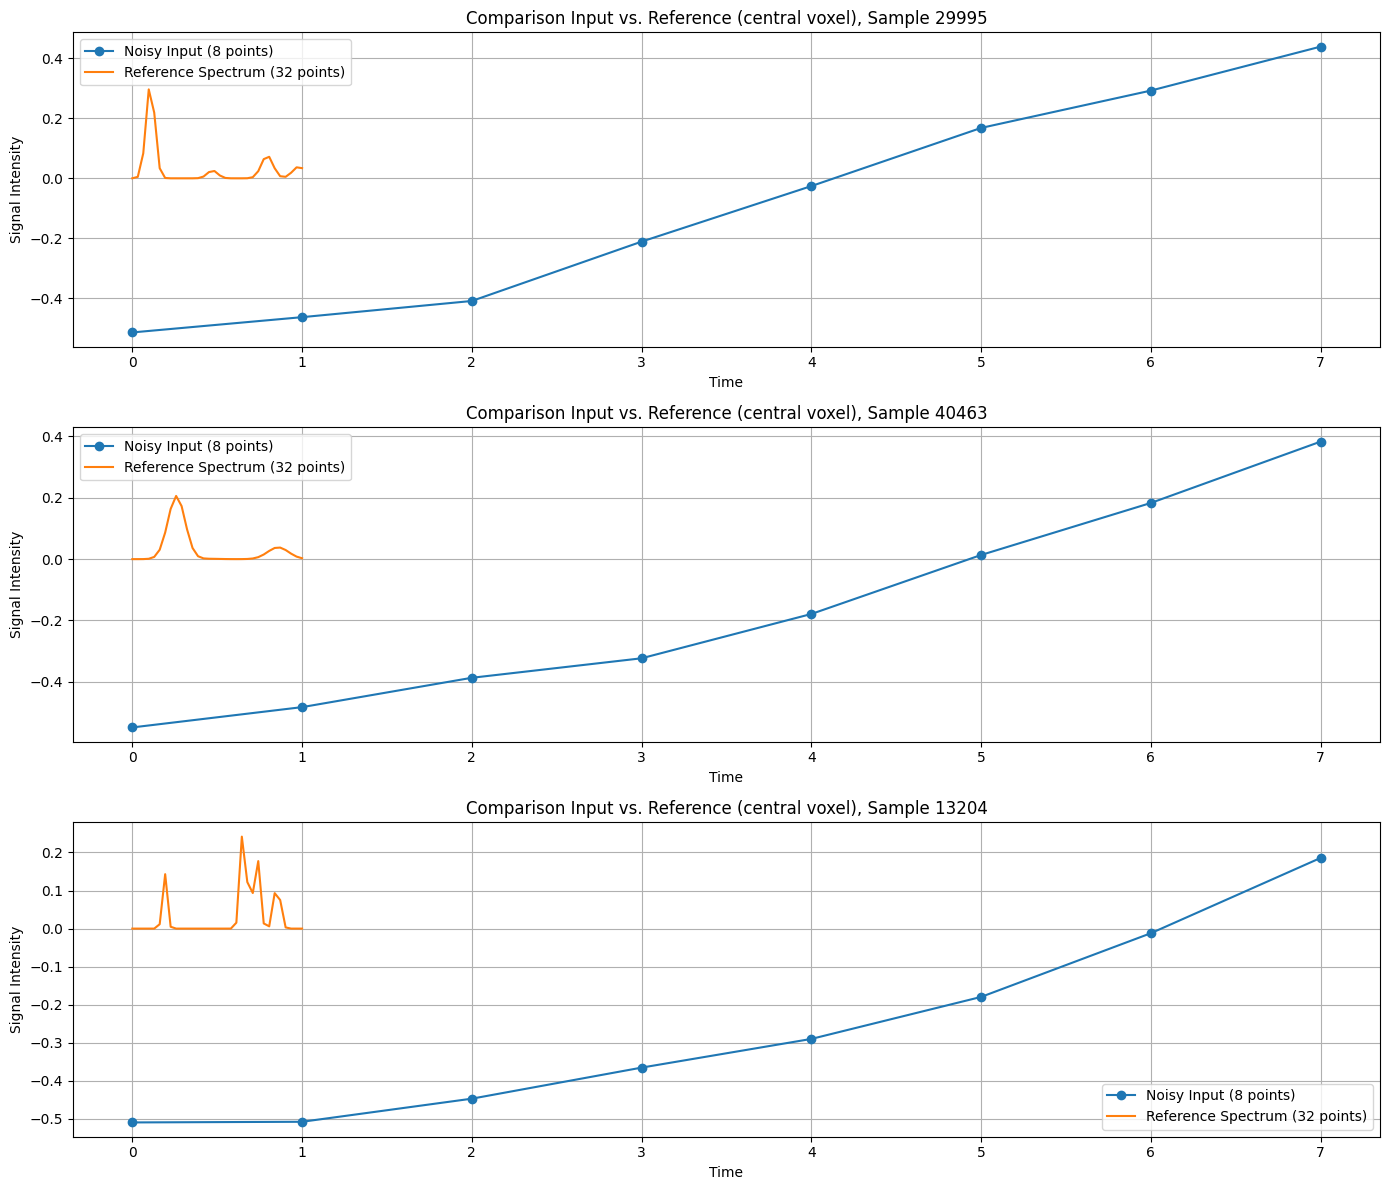

In [21]:
# Direct Comparison of Input and Reference

num_comparisons = 3
random_indices_comparison = np.random.choice(ref.shape[3], size=num_comparisons, replace=False)

plt.figure(figsize=(14, 4 * num_comparisons))
for i, idx in enumerate(random_indices_comparison):
    plt.subplot(num_comparisons, 1, i + 1)
    plt.plot(inversion_times, input_noisy[4, 4, :, idx], 'o-', label='Noisy Input (8 points)')
    plt.plot(t1_times, ref[4, 4, :, idx], '-', label='Reference Spectrum (32 points)')
    plt.title(f"Comparison Input vs. Reference (central voxel), Sample {idx}")
    plt.xlabel("Time")
    plt.ylabel("Signal Intensity")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()